In [16]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pydicom
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from sklearn.model_selection import KFold

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import albumentations as A


transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1.0),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.9),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.6),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=1.0),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=0.9),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([

    A.Normalize(mean=0.5, std=0.5),
])

In [19]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore
SEED = 2222
set_random_seed(SEED)

In [20]:
df = pd.read_csv(f'train.csv')
df = df.fillna(0)
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
cols_to_keep = ['study_id' , "spinal_canal_stenosis_l1_l2" , "spinal_canal_stenosis_l2_l3" , "spinal_canal_stenosis_l3_l4" , "spinal_canal_stenosis_l4_l5" , "spinal_canal_stenosis_l5_s1"  ]
train_desc  = pd.read_csv( 'train_series_descriptions.csv')

df = df[cols_to_keep]
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1
0,4003253,0,0,0,0,0
1,4646740,0,0,1,2,0
2,7143189,0,0,0,0,0
3,8785691,0,0,0,0,0
4,10728036,0,0,0,0,0


In [21]:
model_nmae = 'resnet18'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cord = timm.create_model(model_nmae, pretrained=True , in_chans = 1  , num_classes=2).to(device)
model_cord.load_state_dict(torch.load('unet_axial.pt', weights_only=True))
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])

        label = t[1:].values.astype(np.int64)

        #Axial is 15,1,512,512

        saggital = np.zeros(( 384, 384,5), dtype=np.float32)

        main_sag_dir = f"saggital_t2_levels/{st_id}/"

        levels = os.listdir(main_sag_dir)
        clahe = A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True)

        for i, level in enumerate(levels):
            try:
                #Open middle image
                l = os.listdir(main_sag_dir + level)
                #Sort on the basis of image name
                l = sorted(l, key=lambda x: int(x.split(".")[0]))
                #Ignore those image_names greater than 15
                for x in l:
                    if int(x.split(".")[0]) > 15:
                        l.remove(x)
                middle = l[len(l)//2]
                img = cv2.imread(main_sag_dir + level + "/" + middle, cv2.IMREAD_GRAYSCALE)
                #img = clahe(image=img)['image']
                img = cv2.resize(img, (384, 384))
                saggital[:,:,i] = img
            except:
                continue
        
      
        axial = np.zeros((384,384,3,5), dtype=np.float32)
        main_axial_dir = f"axial_levels_2/{st_id}/"
        levels = os.listdir(main_axial_dir)
        
        for i, level in enumerate(levels):
            l = os.listdir(main_axial_dir + level)
            l = sorted(l, key=lambda x: int(x.split(".")[0]))
            if len(l) < 3:
                #Repeat 0th image
                l = [l[0]]*3
            else:
                l = l[len(l)//2-1:len(l)//2+2]
            for j, img_ax in enumerate(l):
                pth = main_axial_dir + level + "/" + img_ax
                img = Image.open(pth).convert('L')
                #img = clahe(image=np.array(img))['image']
                img = np.array(img)

                img = cv2.resize(img, (384, 384))
                img = torch.tensor(img).float()
                img = img.unsqueeze(0)

                # print (img.shape)
                pred = model_cord(img.unsqueeze(0).to(device))
                pred = pred.cpu().detach().numpy()
                # print (pred)
                x=pred[0][0]
                y=pred[0][1]
                #crop image 0.25 around the predicted point
                img = img.squeeze().cpu().numpy()

                img = img[int(y*384)-80:int(y*384)+80, int(x*384)-80:int(x*384)+80]
                img = cv2.resize(img, (384, 384))

                axial[:,:,j,i] = img

        

        if self.transform:
            x = self.transform(image=saggital)['image']
            for i in range(5):
                for j in range(3):
                    img = axial[:,:,j,i]
                    img = self.transform(image=img)['image']
                    axial[:,:,j,i] = img

        x = torch.tensor(saggital).float()    
        x = x.permute(2,0,1)
        axial = torch.tensor(axial).float()
        axial = axial.permute(3,2,0,1)


        return {'saggital': x, 'axial': axial}, label
    
data = RSNA24Dataset(df, transform=transforms_val)

print (data[0][0]['saggital'].shape)
print (data[0][0]['axial'].shape)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 1 channel(s)


torch.Size([5, 384, 384])
torch.Size([5, 3, 384, 384])


[0 0 1 2 0]


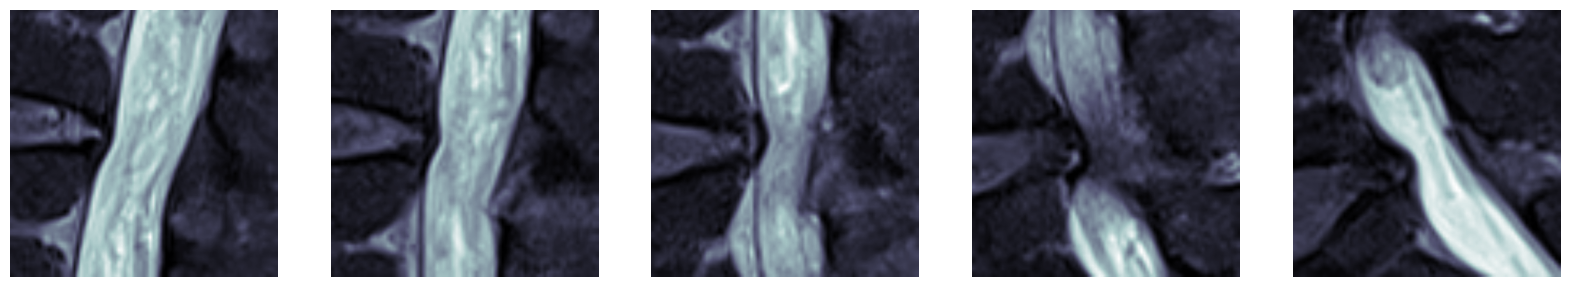

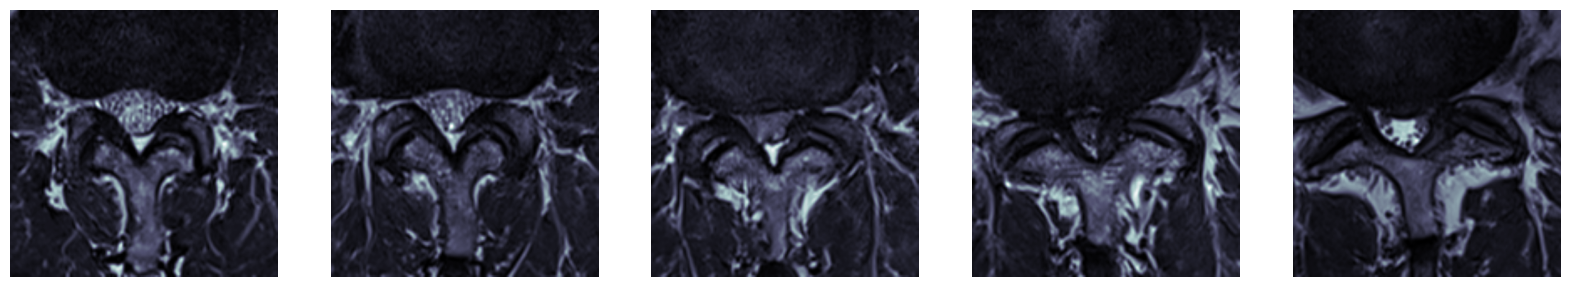

In [22]:
#Plot 
idx =45
print (data[idx][1])
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(data[idx][0]['saggital'][i], cmap='bone')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(data[idx][0]['axial'][i][1], cmap='bone')
    ax[i].axis('off')

plt.show()

In [23]:
# model_nmae = 'efficientnetv2_rw_t.ra2_in1k'
# model = timm.create_model(model_nmae, pretrained=True , in_chans = 1  , num_classes=3)
# #Sag_PreTrainv2.pth
# model.load_state_dict(torch.load('Sag_PreTrain.pth'))
# out = model(data[23][0].unsqueeze(1))
# print(out.argmax(1), data[23][1])
#print(acc/(len(data)*5))


In [24]:
import timm
import torch.nn as nn
from itertools import repeat

class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


import torch
from torch import nn
import torch.nn.functional as F

from typing import Dict, Optional
 
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor



class CFG:

    model_arch= 'efficientnetv2_rw_t.ra2_in1k'
    img_size=400
    seq_len = 24
    dropout=0.1
    multihead=False


class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim

        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x
    

class RSNAClassifier(nn.Module):
    def __init__(self, model_arch, hidden_dim=256, seq_len=24, pretrained=False):
        super().__init__()
        self.seq_len = seq_len
        self.model = timm.create_model(model_arch, in_chans=1, pretrained=pretrained , num_classes=3)
        self.model.load_state_dict(torch.load('Sag_PreTrain.pth'))

        self.model_ax   = timm.create_model(model_arch, in_chans=1, pretrained=pretrained , num_classes=3)
        self.model_ax.load_state_dict(torch.load('unet_axial_main.pt', weights_only=True))

        #freeze
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model_ax.parameters():
            param.requires_grad = False

        if 'efficientnet' in CFG.model_arch:
            cnn_feature = self.model.classifier.in_features
            self.model.classifier = nn.Linear(cnn_feature, 512)
            
            self.model_ax.classifier = nn.Linear(cnn_feature, 512)
            
        elif "res" in CFG.model_arch:
            cnn_feature = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)

        
        self.spatialdropout = SpatialDropout(0.1)

        self.lstm_out = nn.GRU(512, 256, 2, batch_first=True, bidirectional=True)
        self.lstm_out_ax = nn.GRU(512, 256, 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear( 1024, 15)
        self.cross_attn = nn.MultiheadAttention(embed_dim=512, num_heads=2)
        self.cross_attn_2 = nn.MultiheadAttention(embed_dim=512, num_heads=2)
        self.lstm_ax = nn.LSTM(512, 256, 2, batch_first=True, bidirectional=True)       

        




    def forward(self, z): # (B, seq_len, H, W)
        #(bs , vertebrae , slices ,  H , W)
        x = z['saggital']
        ax = z['axial']
        bs = x.size(0)
        x = x.reshape(bs*self.seq_len, 1, 384, 384) # (B*seq_len, 1, H, W)
        embeds = self.model(x) 
        embeds = embeds.reshape(bs, self.seq_len, -1)       # (B, seq_len, cnn_feature)
        out, _ = self.lstm_out(embeds)
        ax = ax.reshape(bs*self.seq_len*3, 1, 384, 384)
        embeds_ax = self.model_ax(ax)
        embed_axial = torch.zeros(bs, self.seq_len, 512).to('cuda')
        for i in range(self.seq_len):
            embed_axial[:,i,:] = self.lstm_ax(embeds_ax[i*3:i*3+3].unsqueeze(0))[0][:,-1,:]

        out_ax, _ = self.lstm_out_ax(embed_axial)
        #out = torch.cat((out, out_ax),1)

        out1 ,_ = self.cross_attn(out_ax, out, out)

        out2 ,_ = self.cross_attn_2(out, out_ax, out_ax)
        out1 = out1[:,-1,:]
        out2 = out2[:,-1,:]
        out2 = self.spatialdropout(out2)
        out1 = self.spatialdropout(out1)

        out = torch.cat((out1, out2),1)


        out = self.fc(out)
        return out

sample = data[0]
model = RSNAClassifier(CFG.model_arch , hidden_dim=256, seq_len=5, pretrained=True).to('cuda')

dataloader = DataLoader(data, batch_size=1, shuffle=True)

for i, (x, y) in enumerate(dataloader):
    x['saggital'] = x['saggital'].to('cuda')
    x['axial'] = x['axial'].to('cuda')
    y = y.to('cuda')
    out = model(x)
    print(out.shape)
    break




INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)


torch.Size([1, 15])


In [25]:

OUTPUT_DIR = f'spinal_canal_stenosis_PRETRAINED__Final_v2'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count()
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IN_CHANS = 42
N_LABELS = 5
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75
N_FOLDS = 5 
EPOCHS = 40

MODEL_NAME = "resnet18"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 5

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [26]:
from sklearn.model_selection import train_test_split
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

if not os.path.exists(OUTPUT_DIR):  
    os.makedirs(OUTPUT_DIR)


val_losses = []
train_losses = []
# skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
#     skippabe_folds = []
#     if fold in skippabe_folds:
#         continue
#     print('#'*30)
#Train test split
val_size = 0.2
df_train, df_valid = train_test_split(df, test_size=val_size, random_state=SEED)

train_ds1 = RSNA24Dataset(df_train, train_desc, transform=transforms_train)
train_ds2 = RSNA24Dataset(df_train, train_desc, transform=transforms_val)
train_ds = torch.utils.data.ConcatDataset([train_ds1, train_ds2])
train_dl = DataLoader(
            train_ds,
            batch_size=1,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            )

valid_ds = RSNA24Dataset(df_valid, train_desc, transform=transforms_val)
valid_dl = DataLoader(
            valid_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            )

model =  RSNAClassifier(CFG.model_arch, hidden_dim=256, seq_len=5, pretrained=True)
model.to(device)
#Load model if available
# try:
#     model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'))
# except:
#     print('failed to load model')
#     pass


optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
num_cycles = 0.475
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=num_total_steps,
                                            num_cycles=num_cycles)

weights = torch.tensor([1.0, 2.0, 4.0])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
criterion2 = nn.CrossEntropyLoss(weight=weights)

best_loss = 1.2
best_wll = 1.2
es_step = 0
best_acc = 0

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)


In [27]:
from sklearn.model_selection import train_test_split
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

if not os.path.exists(OUTPUT_DIR):  
    os.makedirs(OUTPUT_DIR)


val_losses = []
train_losses = []
# skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
#     skippabe_folds = []
#     if fold in skippabe_folds:
#         continue
#     print('#'*30)
#Train test split
val_size = 0.2
df_train, df_valid = train_test_split(df, test_size=val_size, random_state=SEED)

train_ds1 = RSNA24Dataset(df_train, train_desc, transform=transforms_train)
train_ds2 = RSNA24Dataset(df_train, train_desc, transform=transforms_val)
train_ds = torch.utils.data.ConcatDataset([train_ds1, train_ds2])
train_dl = DataLoader(
            train_ds,
            batch_size=1,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            )

valid_ds = RSNA24Dataset(df_valid, train_desc, transform=transforms_val)
valid_dl = DataLoader(
            valid_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            )

model =  RSNAClassifier(CFG.model_arch, hidden_dim=256, seq_len=5, pretrained=True)
model.to(device)
#Load model if available
# try:
#     model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'))
# except:
#     print('failed to load model')
#     pass


optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
num_cycles = 0.475
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=num_total_steps,
                                            num_cycles=num_cycles)

weights = torch.tensor([1.0, 2.0, 4.0])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
criterion2 = nn.CrossEntropyLoss(weight=weights)

best_loss = 1.2
best_wll = 1.2
es_step = 0
best_acc = 0
for epoch in range(1, EPOCHS+1):
    print(f'start epoch {epoch}')
    model.train()
    total_loss = 0
    with tqdm(train_dl, leave=True) as pbar:
        optimizer.zero_grad()
        for idx, (x, t) in enumerate(pbar):  
            x = {k: v.to(device) for k, v in x.items()}
            t = t.to(device)
            
            with autocast:
                loss = 0
                y = model(x)
                for col in range(N_LABELS):
                    pred = y[:,col*3:col*3+3]
                    gt = t[:,col]
                    
                    loss = loss + criterion(pred, gt) / N_LABELS
                    
                total_loss += loss.item()
                if GRAD_ACC > 1:
                    loss = loss / GRAD_ACC

            if not math.isfinite(loss):
                print(f"Loss is {loss}, stopping training")
                sys.exit(1)

            pbar.set_postfix(
                OrderedDict(
                    loss=f'{loss.item()*GRAD_ACC:.6f}',
                    lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                )
            )
            scaler.scale(loss).backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
            
            if (idx + 1) % GRAD_ACC == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()                    

    train_loss = total_loss/len(train_dl)
    print(f'train_loss:{train_loss:.6f}')

    total_loss = 0
    y_preds = []
    labels = []
    
    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x =  {k: v.to(device) for k, v in x.items()}
                t = t.to(device)
                    
                with autocast:
                    loss = 0
                    loss_ema = 0
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]

                        loss = loss + criterion(pred, gt) / N_LABELS
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())
                    
                    total_loss += loss.item()   

    val_loss = total_loss/len(valid_dl)
    
    y_preds = torch.cat(y_preds, dim=0)
    labels = torch.cat(labels)
    val_wll = criterion2(y_preds, labels)
    #acc4
    y_preds = y_preds.argmax(1)
    acc = (y_preds == labels).sum().item() / len(labels)
    print(f'val_acc:{acc:.6f}')
        
    print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')
    if val_loss < best_loss or val_wll < best_wll or acc > best_acc:
        
        es_step = 0

        if device!='cuda:0':
            model.to('cuda:0')                
            
        if val_loss < best_loss:
            print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
            best_loss = val_loss
            fname = f'{OUTPUT_DIR}/best_loss_model_fold-.pt'
            torch.save(model.state_dict(), fname)
            
        if val_wll < best_wll:
            print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
            best_wll = val_wll
            fname = f'{OUTPUT_DIR}/best_wll_model_fold-.pt'
            torch.save(model.state_dict(), fname)
        if best_acc < acc:
            print(f'epoch:{epoch}, best acc updated from {best_acc:.6f} to {acc:.6f}')
            best_acc = acc
            fname = f'{OUTPUT_DIR}/best_acc_model_fold-.pt'
            torch.save(model.state_dict(), fname)       
        if device!='cuda:0':
            model.to(device)
        
    else:
        es_step += 1
        if es_step >= EARLY_STOPPING_EPOCH:
            print('early stopping')
            break  

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv_stem pretrained weights from 3 to 1 channel(s)


start epoch 1


100%|██████████| 3160/3160 [15:25<00:00,  3.41it/s, loss=0.016489, lr=4.997e-05]


train_loss:0.446343


100%|██████████| 395/395 [01:20<00:00,  4.89it/s]


val_acc:0.904304
val_loss:0.257880, val_wll:0.472191
epoch:1, best loss updated from 1.200000 to 0.257880
epoch:1, best wll_metric updated from 1.200000 to 0.472191
epoch:1, best acc updated from 0.000000 to 0.904304
start epoch 2


100%|██████████| 3160/3160 [15:29<00:00,  3.40it/s, loss=0.002577, lr=9.997e-05]


train_loss:0.234520


100%|██████████| 395/395 [01:21<00:00,  4.86it/s]


val_acc:0.887595
val_loss:0.266029, val_wll:0.346192
epoch:2, best wll_metric updated from 0.472191 to 0.346192
start epoch 3


100%|██████████| 3160/3160 [14:45<00:00,  3.57it/s, loss=0.003476, lr=1.500e-04]


train_loss:0.218228


100%|██████████| 395/395 [01:12<00:00,  5.46it/s]


val_acc:0.911392
val_loss:0.227899, val_wll:0.318373
epoch:3, best loss updated from 0.257880 to 0.227899
epoch:3, best wll_metric updated from 0.346192 to 0.318373
epoch:3, best acc updated from 0.904304 to 0.911392
start epoch 4


100%|██████████| 3160/3160 [14:38<00:00,  3.60it/s, loss=0.003903, lr=2.000e-04]


train_loss:0.214459


100%|██████████| 395/395 [01:16<00:00,  5.17it/s]


val_acc:0.921519
val_loss:0.186034, val_wll:0.350639
epoch:4, best loss updated from 0.227899 to 0.186034
epoch:4, best acc updated from 0.911392 to 0.921519
start epoch 5


100%|██████████| 3160/3160 [14:30<00:00,  3.63it/s, loss=0.004738, lr=1.997e-04]


train_loss:0.200906


100%|██████████| 395/395 [01:11<00:00,  5.56it/s]


val_acc:0.930633
val_loss:0.185734, val_wll:0.333606
epoch:5, best loss updated from 0.186034 to 0.185734
epoch:5, best acc updated from 0.921519 to 0.930633
start epoch 6


100%|██████████| 3160/3160 [14:28<00:00,  3.64it/s, loss=0.002137, lr=1.986e-04]


train_loss:0.185465


100%|██████████| 395/395 [01:11<00:00,  5.53it/s]


val_acc:0.938734
val_loss:0.166142, val_wll:0.297445
epoch:6, best loss updated from 0.185734 to 0.166142
epoch:6, best wll_metric updated from 0.318373 to 0.297445
epoch:6, best acc updated from 0.930633 to 0.938734
start epoch 7


100%|██████████| 3160/3160 [14:26<00:00,  3.65it/s, loss=0.054541, lr=1.969e-04]


train_loss:0.177022


100%|██████████| 395/395 [01:12<00:00,  5.49it/s]


val_acc:0.931139
val_loss:0.181440, val_wll:0.282808
epoch:7, best wll_metric updated from 0.297445 to 0.282808
start epoch 8


100%|██████████| 3160/3160 [14:30<00:00,  3.63it/s, loss=0.004757, lr=1.946e-04]


train_loss:0.164279


100%|██████████| 395/395 [01:11<00:00,  5.51it/s]


val_acc:0.936203
val_loss:0.191614, val_wll:0.370376
start epoch 9


100%|██████████| 3160/3160 [14:30<00:00,  3.63it/s, loss=0.458679, lr=1.915e-04]


train_loss:0.151065


100%|██████████| 395/395 [01:12<00:00,  5.47it/s]


val_acc:0.920506
val_loss:0.199820, val_wll:0.417085
start epoch 10


100%|██████████| 3160/3160 [14:34<00:00,  3.61it/s, loss=0.000216, lr=1.879e-04]


train_loss:0.138394


100%|██████████| 395/395 [01:11<00:00,  5.53it/s]


val_acc:0.934177
val_loss:0.215950, val_wll:0.392510
start epoch 11


100%|██████████| 3160/3160 [14:35<00:00,  3.61it/s, loss=0.046790, lr=1.836e-04]


train_loss:0.123581


100%|██████████| 395/395 [01:12<00:00,  5.45it/s]


val_acc:0.913418
val_loss:0.270257, val_wll:0.374562
start epoch 12


100%|██████████| 3160/3160 [14:38<00:00,  3.60it/s, loss=0.003395, lr=1.788e-04]


train_loss:0.107464


100%|██████████| 395/395 [01:13<00:00,  5.39it/s]

val_acc:0.912911
val_loss:0.237703, val_wll:0.419372
early stopping


In [28]:
#Acc on validation set
model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_acc_model_fold-.pt'))
model.eval()
total_loss = 0
y_preds = []
labels = []

with tqdm(valid_dl, leave=True) as pbar:
    with torch.no_grad():
        for idx, (x, t) in enumerate(pbar):

            x =  {k: v.to(device) for k, v in x.items()}
            t = t.to(device)

            with autocast:
                loss = 0
                loss_ema = 0
                y = model(x)
                for col in range(N_LABELS):
                    pred = y[:,col*3:col*3+3]
                    gt = t[:,col]

                    loss = loss + criterion(pred, gt) / N_LABELS
                    y_pred = pred.float()
                    y_preds.append(y_pred.cpu())
                    labels.append(gt.cpu())

                total_loss += loss.item()

val_loss = total_loss/len(valid_dl)

y_preds = torch.cat(y_preds, dim=0)
labels = torch.cat(labels)

val_wll = criterion2(y_preds, labels)
#acc
y_preds2 = y_preds.argmax(1)
acc = (y_preds2 == labels).sum().item() / len(labels)

print(f'val_acc:{acc:.6f}')


100%|██████████| 395/395 [01:12<00:00,  5.49it/s]

val_acc:0.938734


In [29]:
#AUROC
from torchmetrics import AUROC
auroc = AUROC(num_classes=3 , task="MULTICLASS")
y_preds = torch.tensor(y_preds)
labels = torch.tensor(labels)
auroc(y_preds, labels)


tensor(0.9717)

In [30]:
y_preds2 = y_preds.argmax(1)
#change all 2 to 1
labels = labels.cpu().numpy()
labels[labels==2] = 1
y_preds2 = y_preds2.cpu().numpy()
y_preds2[y_preds2==2] = 1

acc = (y_preds2 == labels).sum().item() / len(labels)

print(f'val_acc:{acc:.6f}')

val_acc:0.956456


In [ ]:
#Bin